# Naive Classifier for Fake news recognition

## Packages

In [1]:
library(tidyverse)
library(ggplot2)
library(stopwords)
library(tidytext)
library(stringr)
library(purrr)
library(magrittr)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.4.1     ✔ purrr   1.0.1
✔ tibble  3.2.0     ✔ dplyr   1.1.0
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.4     ✔ forcats 1.0.0

── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()


Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract




# Reading the data

In [2]:
train.filename <- 'dataset/archive/train.csv'
test.filename <- 'dataset/archive/test.csv'

In [3]:
train2.filename <- 'dataset/fake-news/train.csv'
test2.filename <- 'dataset/fake-news/test.csv'

In [4]:
train.df <- read.delim(train.filename, sep = ',')
test.df <- read.delim(test.filename, sep = ',')

In [5]:
# train2.df <- read.delim(train2.filename, sep = ',')
# test2.df <- read.delim(test2.filename, sep = ',')

# Display the train and test datasets

In [6]:
# head(test.df)

In [7]:
# head(train.df)

In [8]:
# head(train2.df)

In [9]:
# head(test2.df)

# Splitting the datasets

In [10]:
# shuffle
set.seed(29062023)
train.df=train.df[sample(1:nrow(train.df), replace = F),] # shuffle the dataset

In [11]:
# set splitting percentages
perc_split <- 0.8  # set splitting percentages
n_rows <- nrow(train.df)
n_rows_train <- floor(n_rows * perc_split)

In [12]:
# splitting
train.df.train <- train.df[1:n_rows_train, ]
train.df.validation <- train.df[-c(1:n_rows_train), ]

In [13]:
cat('Total rows:',nrow(train.df),
    '\nTrain rows:',nrow(train.df.train),
    '\nValidation rows',nrow(train.df.validation))

Total rows: 10240 
Train rows: 8192 
Validation rows 2048

## Analysis of the content

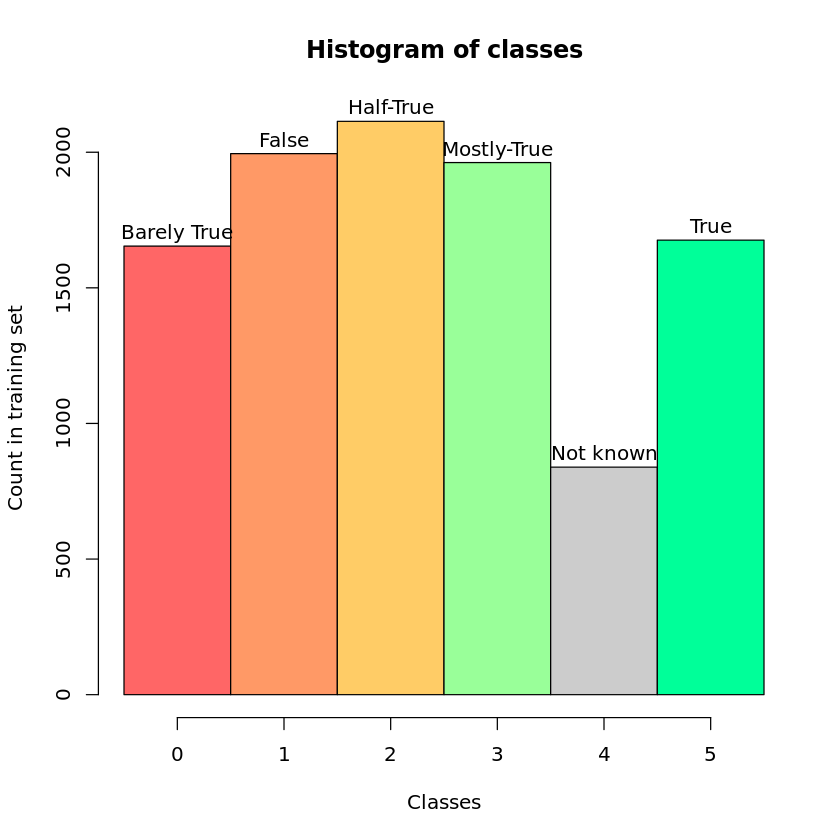

In [14]:
breaks <- seq(from=-0.5, to=5.5, by=1)
labels <- c('Barely True', 'False', 'Half-True', 'Mostly-True', 'Not known', 'True')
colors <- c('#FF6666','#FF9966', '#FFCC66', '#99FF99' , '#CCCCCC','#00FF99')

class<-hist(x = train.df$Labels, 
     breaks = breaks, 
     labels = labels,
     main = 'Histogram of classes',
     xlab = 'Classes',
     ylab = 'Count in training set',
     col = colors
    )

In [15]:
prior.classes<-class$density

# Analysis of the text

In [16]:
train.df.train %>% select(Text) %>% filter(grepl('[a-z]-[a-z]', Text)) %>% head

Text                                                                                                                                                                                 
1 Says Rick Perry flip-flopped on gay marriage by first saying it was a states rights issue and then saying he was in favor of a federal constitutional amendment banning gay marriage.
2 The United States death rate is two-and-a-half times higher for those who do not have a high school education.                                                                       
3 The largest category of people coming into the technical schools in Wisconsin are people with four-year degrees.                                                                     
4 A proposed mine in Wisconsin is about two-thirds the size of Lake Winnebago.                                                                                                         
5 The cost of health care is now the single-biggest factor driving down the federal budget deficit.                                                                                    
6 The Libertarian Party is the third-largest political party in the U.S.

# Vocabulary creation

In [17]:
as.list(get_stopwords())$word

[1] "i"          "me"         "my"         "myself"     "we"        
  [6] "our"        "ours"       "ourselves"  "you"        "your"      
 [11] "yours"      "yourself"   "yourselves" "he"         "him"       
 [16] "his"        "himself"    "she"        "her"        "hers"      
 [21] "herself"    "it"         "its"        "itself"     "they"      
 [26] "them"       "their"      "theirs"     "themselves" "what"      
 [31] "which"      "who"        "whom"       "this"       "that"      
 [36] "these"      "those"      "am"         "is"         "are"       
 [41] "was"        "were"       "be"         "been"       "being"     
 [46] "have"       "has"        "had"        "having"     "do"        
 [51] "does"       "did"        "doing"      "would"      "should"    
 [56] "could"      "ought"      "i'm"        "you're"     "he's"      
 [61] "she's"      "it's"       "we're"      "they're"    "i've"      
 [66] "you've"     "we've"      "they've"    "i'd"        "you'd"     
 [71] "he'd"       "she'd"      "we'd"       "they'd"     "i'll"      
 [76] "you'll"     "he'll"      "she'll"     "we'll"      "they'll"   
 [81] "isn't"      "aren't"     "wasn't"     "weren't"    "hasn't"    
 [86] "haven't"    "hadn't"     "doesn't"    "don't"      "didn't"    
 [91] "won't"      "wouldn't"   "shan't"     "shouldn't"  "can't"     
 [96] "cannot"     "couldn't"   "mustn't"    "let's"      "that's"    
[101] "who's"      "what's"     "here's"     "there's"    "when's"    
[106] "where's"    "why's"      "how's"      "a"          "an"        
[111] "the"        "and"        "but"        "if"         "or"        
[116] "because"    "as"         "until"      "while"      "of"        
[121] "at"         "by"         "for"        "with"       "about"     
[126] "against"    "between"    "into"       "through"    "during"    
[131] "before"     "after"      "above"      "below"      "to"        
[136] "from"       "up"         "down"       "in"         "out"       
[141] "on"         "off"        "over"       "under"      "again"     
[146] "further"    "then"       "once"       "here"       "there"     
[151] "when"       "where"      "why"        "how"        "all"       
[156] "any"        "both"       "each"       "few"        "more"      
[161] "most"       "other"      "some"       "such"       "no"        
[166] "nor"        "not"        "only"       "own"        "same"      
[171] "so"         "than"       "too"        "very"       "will"

In [18]:
# train.df.train %>%
#     select(Text) %>%
#     unnest_tokens(word, Text) %>%
#     anti_join(get_stopwords(), by = join_by(word)) %>%
#     unique %>%
#     arrange(word) -> vocabulary.train

In [19]:
# head(vocabulary.train)

In [20]:
# nrow(vocabulary.train)

# Cleaning functions

In [21]:
cleaning_tokens <- function(token.df){
    word <- ifelse(endsWith(token.df[,1], "s"), substr(token.df[,1], 1, nchar(token.df[,1]) - 1), token.df[,1])
    word <- ifelse(endsWith(word, "'"), substr(word, 1, nchar(word) - 1), word)
    word <- ifelse(str_detect(word, "[0-9]+"), '--number--', word)
#     word %<>% unique
    return(as.data.frame(word))
}

## Clean the vocabulary

In [22]:
# vocabulary.train.cleaned <- cleaning_tokens(token.df = vocabulary.train)

In [23]:
# vocabulary.train.cleaned %>%
#     filter(grepl("\\.", word)) %>%
#     rename(w = word) %>%
#     mutate(len=nchar(w)) %>%
#     arrange(desc(len))

# Feature selection

## With frequency mean

In [24]:
tags_numbers <- list(tags = c('Barely True', 'False', 'Half-True', 'Mostly-True', 'Not known', 'True'),
                     numbers = c(0:5))

In [25]:
myframes <- list()

for (i in 1:length(tags_numbers$tags)) {
    tag <- tags_numbers$tags[i]

    train.df.train %>%
        filter(Labels == tags_numbers$numbers[i]) %>%
        select(Text) %>%
        unnest_tokens(word, Text) %>%
        anti_join(get_stopwords(), by = join_by(word)) %>%
        cleaning_tokens %>%
        arrange(word) %>%
        group_by(word) %>%
        reframe(counts = n()) %>%
        arrange(desc(counts)) %>%
        setNames(c("word", tag)) -> myframes[[i]]
}

In [26]:
counts<-purrr::reduce(myframes, dplyr::full_join, by = 'word')

In [27]:
head(counts)

word       Barely True False Half-True Mostly-True Not known True
1 --number-- 693         784   1106      1157        259       872 
2 say        361         417    411       334        192       268 
3 state      157         214    224       237         60       228 
4 year       154         170    217       224         45       178 
5 obama      134         164    142        84        105        73 
6 percent    121         129    216       243         34       191

In [28]:
counts %<>% replace(is.na(.),0)

In [29]:
counts %>%
    select(-word) %>%
    colSums() -> tot_counts_per_class

In [30]:
counts_prob <- cbind(counts["word"], counts[2:7]/tot_counts_per_class)

In [31]:
counts_prob["mean"] <- rowMeans(counts_prob[2:7])

In [32]:
counts_prob %>%
    arrange(desc(mean)) %>%
    top_frac(0.1, mean) -> vocabulary.train.features

In [33]:
head(vocabulary.train.features)

word       Barely True False       Half-True   Mostly-True Not known  
1 --number-- 0.045383104 0.043625842 0.072429601 0.064381504 0.016961362
2 say        0.020790141 0.056146493 0.023669661 0.044971052 0.011057360
3 obama      0.018042278 0.009444828 0.019119429 0.004837595 0.014137606
4 state      0.007935305 0.014492754 0.011321708 0.016050386 0.003032600
5 year       0.008569362 0.011132940 0.012075010 0.014669286 0.002504034
6 tax        0.005471090 0.014676181 0.006450127 0.014541538 0.002361207
  True       mean       
1 0.04852262 0.048550672
2 0.03608456 0.032119877
3 0.00420410 0.011630973
4 0.01544088 0.011378938
5 0.01165684 0.010101246
6 0.01050222 0.009000394

In [34]:
counts %>%
    right_join(vocabulary.train.features["word"], by = join_by(word)) -> naive.bayes.vocabulary

In [35]:
length(naive.bayes.vocabulary[[1]])

[1] 908

In [36]:
den <- tot_counts_per_class + length(naive.bayes.vocabulary[[1]])

In [37]:
den

Barely True       False   Half-True Mostly-True   Not known        True 
      16178       18272       20693       18879        8335       15674

In [38]:
likelihood.token <- cbind(naive.bayes.vocabulary["word"], (naive.bayes.vocabulary[2:7] + 1)/den)

In [39]:
# is.na(log(as.numeric(likelihood.token[likelihood.token['word']=='ciao'][2:6])))

# is.na(likelihood.token[likelihood.token['word']=='ciao'])

In [40]:
msg<-c('obama', 'percent', 'tommasomarco')

In [41]:
query_out <- log(as.numeric(prior.classes))
for (i in 1:length(msg)) {
    query <- log(as.numeric(likelihood.token[likelihood.token["word"] == msg[i]][2:7]))
    if (is.na(query[1])) {
        query <- as.numeric(log(1/den))
    }
    #### query is log likelihood for each class
    query_out <- query_out + query

}
cat(exp(query_out), "\n")

1.25869e-09 7.737015e-10 7.924553e-10 1.611177e-09 1.233728e-10 3.797736e-10 


## With absolute counts per class
To implement

In [ ]:
# train.df.train %>%
#     filter(Labels == 5) %>%
#     select(Text) %>%
#     unnest_tokens(word, Text) %>%
#     anti_join(get_stopwords(), by = join_by(word)) %>%
#     arrange(word) %>%
#     group_by(word) %>%
#     reframe(counts=n()) %>%
#     arrange(desc(counts)) -> true

## Naive Bayes Classifier

#### Some suggestion to create equivalence classes

In [ ]:
vocabulary.train %>%
    filter(grepl("al", word)) %>%
    head

In [ ]:
vocabulary.train.cleaned %>%
    filter(grepl("\\'s", word))

In [ ]:
train.df %>%
    filter(grepl("06", Text)) %>%
    filter(!grepl("2006", Text))  #%>% summarise(n())

## About the data

# Count how many topics there are

In [ ]:
train.df.train %>%
    select(Text_Tag) %>%
    unnest_tokens(word, Text_Tag, token = stringr::str_split, pattern = ",") %>%
    unique %>%
    arrange(word) -> topics

In [ ]:
train.df.train  %>% filter(Text_Tag=='')

In [ ]:
topics<-as.list(topics)$word

#### Number of unique topics

In [ ]:
length(topics)

#### Most frequent and infrequent topics

In [ ]:
counts<-vector()
for(i in seq_along(topics)){
    counts[i]<- as.numeric(train.df.train %>% filter(grepl(topics[i], Text_Tag)) %>% summarise(n()))
    }

In [ ]:
topics_counts <- data.frame(topics, counts)

In [ ]:
topics_counts %>%
    filter(topics != "") %>%
    arrange(desc(counts)) %>%
    head()

In [ ]:
topics_counts %>%
    arrange(counts) %>%
    head()